# Amazon Employee Access Challenge

## About The Data

The data consists of real historical data collected from 2010 & 2011.  Employees are manually allowed or denied access to resources over time. We will try to create a logistic regression model capable of learning from this historical data to predict approval/denial for an unseen set of employees.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score


We start by loading the data

In [2]:
train_data= pd.read_csv('../../data/original data/amazon-employee-access-challenge/train.csv')
test_data = pd.read_csv('../../data/original data/amazon-employee-access-challenge/test.csv')

Extracting the target feature values

In [3]:
y = train_data['ACTION'].values
X_combined = pd.concat([train_data.drop('ACTION', axis=1), test_data.drop('id', axis=1)], axis=0)
num_train = len(train_data)

Since the data was a set of categorical values (IDs of the roles), we will hot encode the instances

In [4]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
X_encoded = encoder.fit_transform(X_combined)

In [5]:
X_train_encoded = X_encoded[:num_train]
X_test_encoded = X_encoded[num_train:]

The model we will work with as requested is the **Logistic Regression**, we will now cross-validate the model chosen

In [6]:
model = LogisticRegression(C=1.0, solver='liblinear', max_iter=1000)

kf = KFold(n_splits=10, shuffle=True, random_state=42)
aucs = []

for train_idx, val_idx in kf.split(X_train_encoded):
    model.fit(X_train_encoded[train_idx], y[train_idx])
    preds = model.predict_proba(X_train_encoded[val_idx])[:, 1]
    auc = roc_auc_score(y[val_idx], preds)
    aucs.append(auc)

mean_auc = np.mean(aucs)
print(f"Cross-validated AUC: {mean_auc:.4f}")


Cross-validated AUC: 0.8646


The metric used for evaluating the model is the AUC, we avoided using the accuracy because of the huge data imbalance of the target feature

A score of 0.8646 on the cross-validation is not a bad one, so we continue with it and train the model on all instances and predict on test data

In [7]:
model.fit(X_train_encoded, y)
pred_probs = model.predict_proba(X_test_encoded)[:, 1]
pred_classes = (pred_probs > 0.5).astype(int)

### Adding some features

The model's performance was overall good, but we can make it better by adding some expressive features for the model

For that we will use a **Feature Cobination** tichnique where n features will be combined every iteration creating new data dimensions

In [8]:
import pandas as pd
import numpy as np
import random
import time
from itertools import combinations
from numpy import array
from scipy import sparse
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score


We start by grouping the training ad testing data, since this method uses the frequency of rows patterns

In [9]:
all_data = np.vstack((train_data.iloc[:, 1:], test_data.iloc[:, 1:]))
num_train = train_data.shape[0]
y = array(train_data['ACTION'])


We now set a threshold of 3 minimum occurences of a combination to be selectedm and iterate to all features starting pairwise until combining all the existing 7 features.

In [10]:
min_occurs = 3
degrees = [2, 3, 4, 5, 6, 7]

def dict_encode(encoding, value):
    if value not in encoding:
        encoding[value] = {'code': len(encoding) + 1, 'count': 0}
    enc = encoding[value]
    enc['count'] += 1
    encoding[value] = enc

def dict_decode(encoding, value, min_occurs):
    enc = encoding.get(value, {'code': -1, 'count': 0})
    return enc['code'] if enc['count'] >= min_occurs else -1

def group_data(data, degree, min_occurs):
    m, n = data.shape
    encoding = dict()
    for indexes in combinations(range(n), degree):
        for v in data[:, indexes]:
            dict_encode(encoding, tuple(v))
    new_data = []
    for indexes in combinations(range(n), degree):
        new_data.append([dict_decode(encoding, tuple(v), min_occurs) for v in data[:, indexes]])
    return array(new_data).T

grouped_data = [group_data(all_data, degree=d, min_occurs=min_occurs) for d in degrees]


In [11]:
X_train_all = np.hstack([all_data[:num_train]] + [d[:num_train] for d in grouped_data])
X_test_all = np.hstack([all_data[num_train:]] + [d[num_train:] for d in grouped_data])

num_features = X_train_all.shape[1]
print(f"Total number of categorical features: {num_features}")


Total number of categorical features: 501


This resulted in a new dataset with 501 feature, even though it is a big number, we will consider adding some expressive features below. This is because:
1. Not all 501 features are useful — most are "dead weight"
2. Linear Models can't capture non-linear interactions by themselves, so we manually engineer additional "interaction" features by combining them 

We set up the logistic regression model

In [12]:
seed = 123
rnd = random.Random(seed * num_features)
model = linear_model.LogisticRegression()
model.C = 0.5 + rnd.random() * 3.5
print(f"Logistic Regression C parameter: {model.C:.4f}")


Logistic Regression C parameter: 3.3434


We prepare the separete one-hot encoding for the datset features since it contains categorical values

In [13]:
def one_hot_encoder(data, keymap=None):
    if keymap is None:
        keymap = []
        for col in data.T:
            uniques = set(list(col))
            keymap.append(dict((key, i) for i, key in enumerate(uniques)))
    total_pts = data.shape[0]
    outdat = []
    for i, col in enumerate(data.T):
        km = keymap[i]
        num_labels = len(km)
        spmat = sparse.lil_matrix((total_pts, num_labels))
        for j, val in enumerate(col):
            if val in km:
                spmat[j, km[val]] = 1
        outdat.append(spmat)
    outdat = sparse.hstack(outdat).tocsr()
    return outdat, keymap

Xts = [one_hot_encoder(X_train_all[:, [i]])[0] for i in range(num_features)]


In [14]:
total_new_features = sum(X_encoded_col.shape[1] for X_encoded_col in Xts)
print(f"Total number of new features after one-hot encoding: {total_new_features}")


Total number of new features after one-hot encoding: 2008898


As we can see, this increased the number of features to more than 2 million feature. So we need to choose a subset of the best features to be used with our model

For that we will use the function defined below that greedily selects the best subset of features that increase AUC.

In [43]:
good_features = set()
score_hist = []
f_remain = list(range(len(Xts)))
cur_best_score = -1
cur_best_score_thres = 1.0

N = 10

def cv_loop(X, y, model, N, seed):
    mean_auc = 0.0
    k_fold = KFold(n_splits=N, shuffle=True, random_state=seed)
    for train_ix, test_ix in k_fold.split(X):
        model.fit(X[train_ix], y[train_ix])
        preds = model.predict_proba(X[test_ix])[:, 1]
        auc = roc_auc_score(y[test_ix], preds)
        mean_auc += auc
    return mean_auc / N

while len(score_hist) < 2 or score_hist[-1][0] > score_hist[-2][0]:
    scores = []
    f_shuff = f_remain[:]
    random.shuffle(f_shuff)
    n_thres = 0.3679 * len(f_remain)
    iter_best_score = -1
    for i, f in enumerate(f_shuff):
        feats = list(good_features) + [f]
        Xt = sparse.hstack([Xts[j] for j in feats]).tocsr()
        score = cv_loop(Xt, y, model, N, seed)
        if score < (cur_best_score * cur_best_score_thres):
            f_remain.remove(f)
        else:
            scores.append((score, f))
            if score > iter_best_score:
                iter_best_score = score
                if i > n_thres and score > cur_best_score:
                    break
    if scores:
        best_score = sorted(scores)[-1]
        f_remain.remove(best_score[1])
        if best_score[0] > cur_best_score:
            good_features.add(best_score[1])
            score_hist.append(best_score)
            cur_best_score = best_score[0]
        print(f"Current features: {list(good_features)} AUC: {best_score[0]:.5f}")
    else:
        break

good_features = sorted(list(good_features))
print(f"Selected features: {good_features}")


Current features: [440] AUC: 0.84811
Current features: [440, 0] AUC: 0.87628
Current features: [440, 0, 45] AUC: 0.88617
Current features: [440, 0, 45, 247] AUC: 0.89411
Current features: [0, 45, 493, 247, 440] AUC: 0.89649
Current features: [0, 45, 493, 150, 247, 440] AUC: 0.89945
Current features: [0, 7, 45, 493, 150, 247, 440] AUC: 0.90076
Current features: [0, 7, 45, 493, 179, 150, 247, 440] AUC: 0.90168
Current features: [0, 7, 45, 493, 77, 179, 150, 247, 440] AUC: 0.90227
Selected features: [0, 7, 45, 77, 150, 179, 247, 440, 493]


After selecting the Hyperparameters to be used, we fine tune the models parameters

In [15]:
good_features = set()
score_hist = []
f_remain = list(range(len(Xts)))
cur_best_score = -1
cur_best_score_thres = 1.0

N = 10

In [16]:
good_features = set([0, 7, 45, 77, 150, 179, 247, 440, 493])


In [17]:
def cv_loop(X, y, model, N, seed):
    mean_auc = 0.0
    k_fold = KFold(n_splits=N, shuffle=True, random_state=seed)
    for train_ix, test_ix in k_fold.split(X):
        model.fit(X[train_ix], y[train_ix])
        preds = model.predict_proba(X[test_ix])[:, 1]
        auc = roc_auc_score(y[test_ix], preds)
        mean_auc += auc
    return mean_auc / N

In [18]:
Xt = sparse.hstack([Xts[j] for j in good_features]).tocsr()
score_hist = []
score = cv_loop(Xt, y, model, N, seed)
score_hist.append((score, model.C))

Cvals = np.logspace(-3, 4, 20, base=2)

for C in Cvals:
    model.C = C
    score = cv_loop(Xt, y, model, N, seed)
    score_hist.append((score, C))
    print(f"C: {C:.4f} | Mean AUC: {score:.5f}")

model.C = sorted(score_hist)[-1][1]
print(f"Best C: {model.C:.4f}")


C: 0.1250 | Mean AUC: 0.87009
C: 0.1614 | Mean AUC: 0.87802
C: 0.2083 | Mean AUC: 0.88478
C: 0.2689 | Mean AUC: 0.89095
C: 0.3472 | Mean AUC: 0.89552
C: 0.4482 | Mean AUC: 0.89905
C: 0.5786 | Mean AUC: 0.90137
C: 0.7469 | Mean AUC: 0.90276
C: 0.9642 | Mean AUC: 0.90353
C: 1.2447 | Mean AUC: 0.90386
C: 1.6068 | Mean AUC: 0.90382
C: 2.0743 | Mean AUC: 0.90337
C: 2.6778 | Mean AUC: 0.90293
C: 3.4569 | Mean AUC: 0.90224
C: 4.4626 | Mean AUC: 0.90123
C: 5.7610 | Mean AUC: 0.89993
C: 7.4371 | Mean AUC: 0.89892
C: 9.6008 | Mean AUC: 0.89754
C: 12.3941 | Mean AUC: 0.89613
C: 16.0000 | Mean AUC: 0.89525
Best C: 1.2447


And now we one-hot encode the features values to be inputed to the prediction model

In [19]:
good_features = [0, 7, 45, 77, 150, 179, 247, 440, 493] 

In [20]:
Xt = np.vstack((X_train_all[:, good_features], X_test_all[:, good_features]))
Xt, keymap = one_hot_encoder(Xt)

X_train = Xt[:num_train]
X_test = Xt[num_train:]


Final training of the model

In [21]:
model.fit(X_train, y)


LogisticRegression(C=1.244692589464023)

And we can see its performance

In [22]:
N = 10  
kf = KFold(n_splits=N, shuffle=True, random_state=42)

aucs = []


for train_idx, val_idx in kf.split(X_train):
    model.fit(X_train[train_idx], y[train_idx])
    
    preds_proba = model.predict_proba(X_train[val_idx])[:, 1]
    
    auc = roc_auc_score(y[val_idx], preds_proba)
    aucs.append(auc)

mean_auc = np.mean(aucs)
print(f'Mean AUC after {N}-fold cross-validation: {mean_auc:.5f}')

Mean AUC after 10-fold cross-validation: 0.90215


For more insights of the model's performance, here's the classification report

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

preds = (preds_proba >= 0.5).astype(int)



print("\nClassification Report:")
print(classification_report(y[val_idx], preds, zero_division=0))


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.33      0.46       180
           1       0.96      0.99      0.98      3096

    accuracy                           0.96      3276
   macro avg       0.86      0.66      0.72      3276
weighted avg       0.95      0.96      0.95      3276



And down here the plots of the confusion matrix and the ROC curve

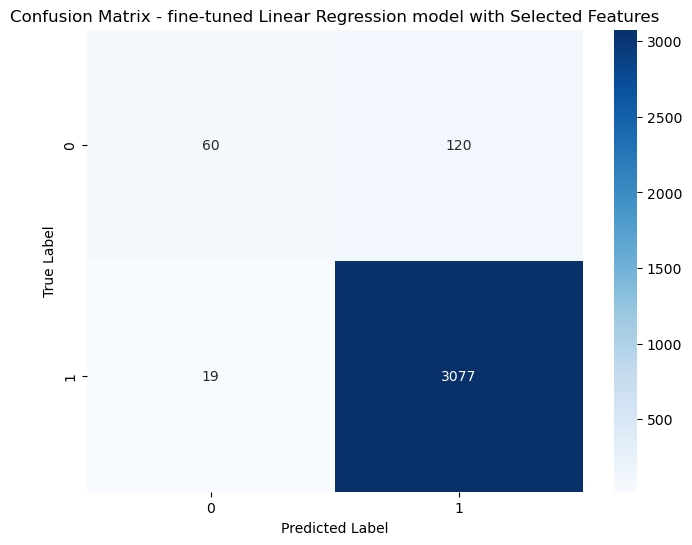

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_best = confusion_matrix(y[val_idx], preds)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - fine-tuned Linear Regression model with Selected Features')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

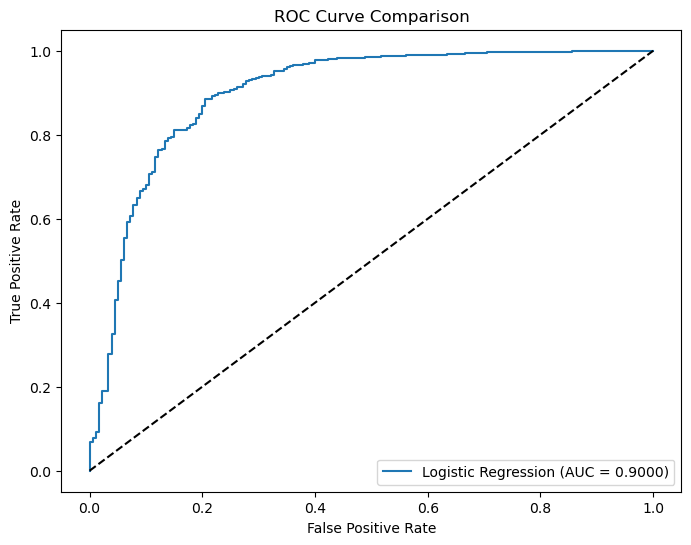

In [28]:
#plot AUC plot

fpr_best, tpr_best, _ = roc_curve(y[val_idx], preds_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr_best, tpr_best, label=f'Logistic Regression (AUC = {roc_auc_score(y[val_idx], preds_proba):.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

**Exporting the best model**

In [48]:
import pickle

with open('../../models/classification task/logistic_regression.pkl', 'wb') as file:
    pickle.dump(model, file)


# Conclusion

The feature engineering tichnique to add new features and use gready search to select the best ones resulted in going from 0.86 to 0.90215 AUC score with 10-fold cross-validation test.